#Importing Dependencies

In [ ]:
import os
import cv2
import numpy as np
import random
from matplotlib import pyplot
import zipfile
import tensorflow as tf
from tensorflow.keras.applications import inception_v3, resnet, Xception
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras import metrics
from tensorflow.keras import optimizers
from tensorflow.keras import backend

In [1]:
from google.colab import drive
drive.mount('content/')

Mounted at content/


In [ ]:

# Replace 'your_rar_file.rar' with the path to your RAR file
zip_file_path = '/content/content/Othercomputers/Lenovo (1)/Machine_Learning/Miscellenous/Zeba/Face Dataset.zip'

# Replace 'your_extraction_directory' with the directory where you want to extract the files
extraction_directory = '/content/content/Othercomputers/Lenovo (1)/Machine_Learning/Miscellenous/Zeba/'

# Open and extract the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_directory)

print(f"ZIP file '{zip_file_path}' has been successfully extracted to '{extraction_directory}'.")


ZIP file '/content/content/Othercomputers/Lenovo (1)/Machine_Learning/Miscellenous/Zeba/Face Dataset.zip' has been successfully extracted to '/content/content/Othercomputers/Lenovo (1)/Machine_Learning/Miscellenous/Zeba/'.


# Data Partition

In [3]:

# RootDir = "ML_Projects/New_ML/Zeba/Face Data/Face Dataset"
RootDir = "/content/content/Othercomputers/Lenovo (1)/Machine_Learning/Miscellenous/Zeba/Face Dataset"

# Go over the data, read file names and split them into train and test
def index_and_split_data(percentage):
    # Get data
    people_count = len(os.listdir(RootDir))
    print("Found images of", people_count, "people.")
    train_index, test_index = {}, {}
    n_train, n_test = 0, 0
    total = 0
    for name in os.listdir(RootDir):
        path = RootDir + "/" + name
        n = len(os.listdir(path))
        total += n
        if np.random.rand() < percentage:
            train_index[name] = n
            n_train += 1
        else:
            test_index[name] = n
            n_test += 1
    print("Found a total of", total, "images.")
    return n_train, train_index, n_test, test_index


# Run the previous function
n_train, train_list, n_test, test_list = index_and_split_data(0.9)
print("Split the people into", n_train, "for training and", n_test, "for testing.")

Found images of 1680 people.
Found a total of 8204 images.
Split the people into 1543 for training and 137 for testing.


# Preprocessing data into triplets

In [4]:
# Use the file names to generate triplets
def get_triplets(index):
    data = []
    for person in index:
        d = index[person]
        anc_no, pos_no = np.random.choice(d, 2, replace=False)
        anchor = RootDir + "/" + person + "/" + str(anc_no) + ".jpg"
        positive = RootDir + "/" + person + "/" + str(pos_no) + ".jpg"

        # Ensure we select "other_person" to be different from "person"
        other_person = int(person)
        while other_person == int(person):
            other_person = int(random.choice(list(index.items()))[0])

        negative = RootDir + "/" + str(other_person) + "/"
        negative += str(np.random.randint(index[str(other_person)])) + ".jpg"
        data.append([anchor, positive, negative])
    random.shuffle(data)
    return data


# Generate triplets for all people, and print the names of the first few files
triplets = get_triplets(train_list)
for i, triplet in enumerate(triplets):
    if i == 5:
        break
    print(triplet)

['/content/content/Othercomputers/Lenovo (1)/Machine_Learning/Miscellenous/Zeba/Face Dataset/1601/0.jpg', '/content/content/Othercomputers/Lenovo (1)/Machine_Learning/Miscellenous/Zeba/Face Dataset/1601/1.jpg', '/content/content/Othercomputers/Lenovo (1)/Machine_Learning/Miscellenous/Zeba/Face Dataset/668/1.jpg']
['/content/content/Othercomputers/Lenovo (1)/Machine_Learning/Miscellenous/Zeba/Face Dataset/1661/0.jpg', '/content/content/Othercomputers/Lenovo (1)/Machine_Learning/Miscellenous/Zeba/Face Dataset/1661/3.jpg', '/content/content/Othercomputers/Lenovo (1)/Machine_Learning/Miscellenous/Zeba/Face Dataset/91/1.jpg']
['/content/content/Othercomputers/Lenovo (1)/Machine_Learning/Miscellenous/Zeba/Face Dataset/445/1.jpg', '/content/content/Othercomputers/Lenovo (1)/Machine_Learning/Miscellenous/Zeba/Face Dataset/445/0.jpg', '/content/content/Othercomputers/Lenovo (1)/Machine_Learning/Miscellenous/Zeba/Face Dataset/392/0.jpg']
['/content/content/Othercomputers/Lenovo (1)/Machine_Learn

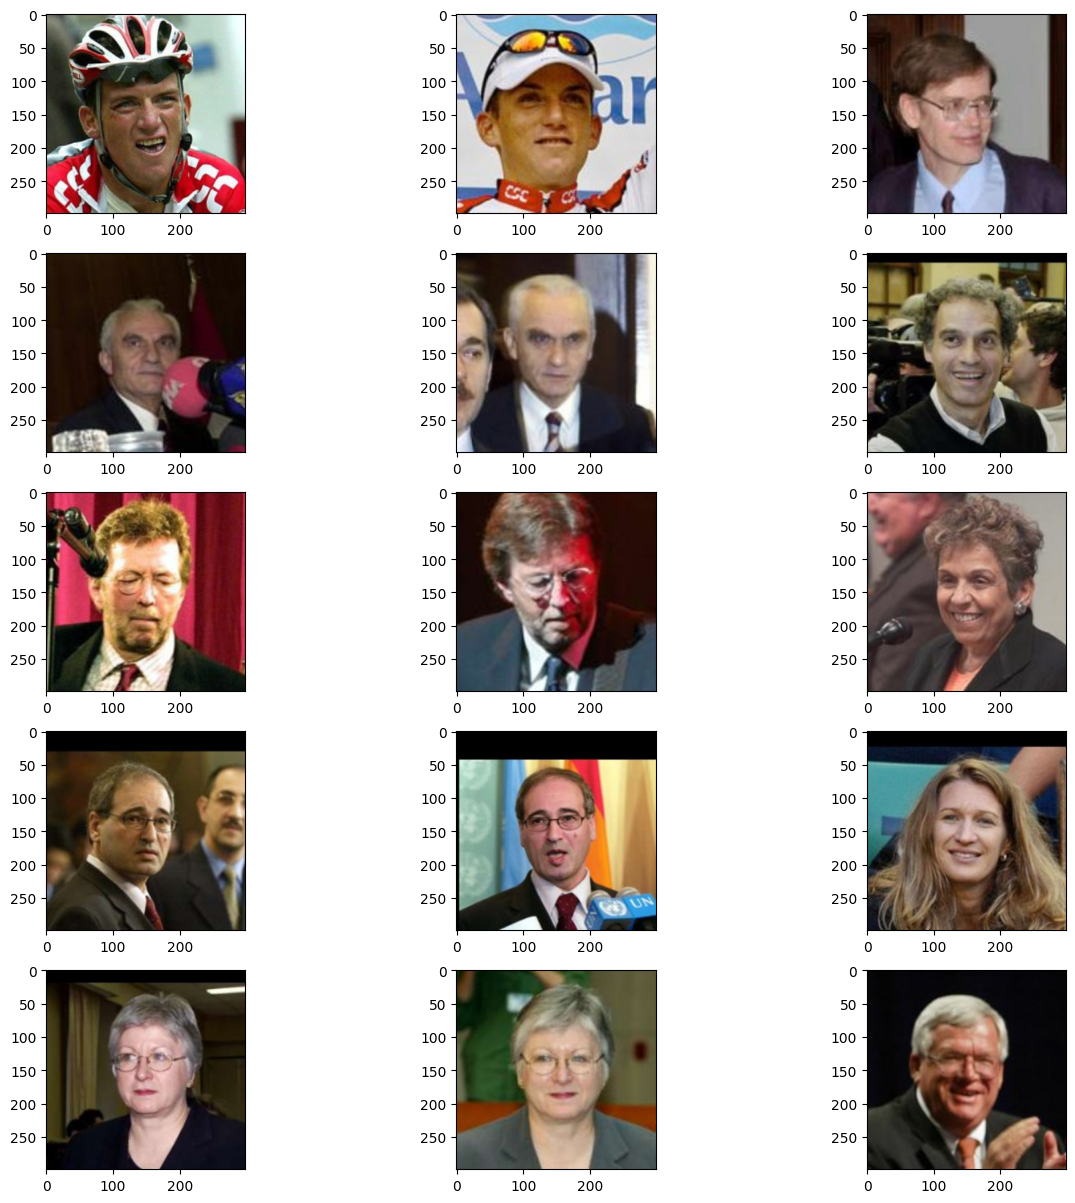

In [5]:
# Parameters to do with images
Width = 299
Height = 299
Channels = 3
shape = (Width, Height, Channels)
Batch_Size = 32

# Read a single image, resize and convert it to RGB
def read_image(filename):
    image = cv2.imread(filename)
    image = cv2.resize(image, (Width, Height))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

# Read all triplets of images
def get_images(data):
    n = len(data)
    anchor_data = np.zeros((n, Width, Height, Channels))
    pos_data = np.zeros((n, Width, Height, Channels))
    neg_data = np.zeros((n, Width, Height, Channels))
    for i, triplet in enumerate(data):
        anchor_name, pos_name, neg_name = triplet
        anchor_data[i] = read_image(anchor_name)
        pos_data[i] = read_image(pos_name)
        neg_data[i] = read_image(neg_name)
    return anchor_data, pos_data, neg_data


# Print a few triplets to see what we have
def print_images(a, p, n, flag):
    # display a  sample of images
    pyplot.figure(figsize=(15,15))
    for i in range(a.shape[0]):
        pyplot.subplot(a.shape[0], 3, 1 + i*3)
        pyplot.imshow(a[i].astype(int))
        pyplot.subplot(a.shape[0], 3, 2 + i*3)
        pyplot.imshow(p[i].astype(int))
        pyplot.subplot(a.shape[0], 3, 3 + i*3)
        pyplot.imshow(n[i].astype(int))
    if flag == 0:  # briefly display images and continue
        pyplot.show(block=False)
        pyplot.pause(3)
        pyplot.close()
    else:  # wait for user to close window
        pyplot.show()


anchor, pos, neg = get_images(triplets[0:5])
print_images(anchor, pos, neg, 0)

In [6]:
# model = inception_v3.InceptionV3(include_top=False, weights="imagenet", input_shape=shape)
# prep = inception_v3.preprocess_input

model = resnet.ResNet50(include_top=False, weights="imagenet", input_shape=shape)
prep = resnet.preprocess_input

# model = Xception(include_top=False, weights='imagenet', input_shape=shape, pooling='max')
# prep = inception_v3.preprocess_input

def get_base_model():
    flatten = layers.Flatten()(model.output)
    dense1 = layers.Dense(512, activation="relu", name="cutoff_dense")(flatten)
    dense1 = layers.BatchNormalization()(dense1)
    dense2 = layers.Dense(256, activation="relu")(dense1)
    dense2 = layers.BatchNormalization()(dense2)
    output = layers.Dense(256)(dense2)

    base_model = Model(model.input, output, name="Base-Model")

    trainable = False
    for layer in base_model.layers:
        if layer.name == "cutoff_dense":
            trainable = True
        layer.trainable = trainable
    # base_model.summary()
    return base_model


encoder = get_base_model()
print("Got basic model.")

94765736/94765736 [==============================] - 1s 0us/step
Got basic model.


#Building Siamese model

In [13]:
class DistanceLayer(layers.Layer):
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


class SiameseModel(Model):
    # Builds a Siamese model based on a base-model
    def __init__(self, siamese_network, margin=1.0):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # Use GradientTape so we can get the gradients once we compute the loss,
        # and use them to update the weights
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients,
                                           self.siamese_network.trainable_weights))
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # Get the two distances from the network, then compute the triplet loss
        ap_distance, an_distance = self.siamese_network(data)
        loss = tf.maximum(ap_distance - an_distance + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics so the reset_states() can be called automatically.
        return [self.loss_tracker]


anchor_input = layers.Input(name="anchor", shape=shape)
positive_input = layers.Input(name="positive", shape=shape)
negative_input = layers.Input(name="negative", shape=shape)

distances = DistanceLayer()(
    encoder(prep(anchor_input)),
    encoder(prep(positive_input)),
    encoder(prep(negative_input)),
)

siamese_network = Model(inputs=[anchor_input, positive_input, negative_input],
                        outputs=distances)
siamese_model = SiameseModel(siamese_network)
opt = optimizers.Adam(learning_rate=1e-4)
siamese_model.compile(optimizer=opt)

print("Got Siamese model.")

Got Siamese model.


In [29]:
TF_ENABLE_ONEDNN_OPTS=1
# tf.config.run_functions_eagerly(True)
# tf.data.experimental.enable_debug_mode()

# Training Siamese Mode

In [202]:
len(test_list)

188

In [18]:

def check_test_data(test_list, n_test):
    # Get metrics on test data
    test_triplets = get_triplets(test_list)
    pos_scores, neg_scores = [], []

    for batch_no in range(int(n_test / Batch_Size)):
        start, end = batch_no * Batch_Size, (batch_no + 1) * Batch_Size
        anchor, pos, neg = get_images(test_triplets[start:end])
        pred = siamese_model([anchor, pos, neg])
        pos_scores += list(pred[0].numpy())
        neg_scores += list(pred[1].numpy())
    acc = np.sum(np.array(pos_scores) < np.array(neg_scores)) / len(pos_scores)
    means = (np.mean(pos_scores), np.mean(neg_scores))
    stds = (np.std(pos_scores), np.std(neg_scores))
    mins = (np.min(pos_scores), np.min(neg_scores))
    maxs = (np.max(pos_scores), np.max(neg_scores))
    print("Acc:", acc, "Means:", means, "stds:", stds)
    metrics = [acc, means, stds, mins, maxs]
    return metrics


# Train model and save the best weights
def train_and_save_weights():
    Epochs = 1
    metrics = []
    training_loss = []

    for epoch in range(Epochs):
        # Select triplets for this epoch
        triplets = get_triplets(train_list)
        losses = []

        # Run epoch training
        for batch_no in range(int(n_train / Batch_Size)):
            start, end = batch_no * Batch_Size, (batch_no + 1) * Batch_Size
            anchor, pos, neg = get_images(triplets[start:end])
            loss = siamese_model.train_on_batch([anchor, pos, neg]) / Batch_Size
            losses.append(loss)
        epoch_loss = np.mean(losses)
        print("Epoch:", epoch, "Loss:", epoch_loss)
        training_loss.append(epoch_loss)

        # Get metrics on test data
        metrics.append(check_test_data(test_list, n_test))

        # Update learning rate
        if epoch == 2:
            print("LR now 1e-5.")
            backend.set_value(opt.lr, 1e-5)
        if epoch == 4:
            print("LR now 1e-6.")
            backend.set_value(opt.lr, 1e-6)

    # Save weights
    siamese_model.save_weights("final_weights")
    return training_loss, metrics

# loss, metrics = train_and_save_weights()

In [10]:
# model_path = 'ML_Projects/New_ML/Zeba/'
# siamese_model.save_weights(model_path+"siamese_final_weights")

In [29]:
# model_path+"/checkpoint"

'ML_Projects/Machine_Learning/Miscellenous/Zeba Attendance system//checkpoint'

In [22]:
# os.listdir(model_path)

In [19]:
from tensorflow import keras
model_path = '/content/content/Othercomputers/Lenovo (1)/Machine_Learning/Miscellenous/Zeba/'
# Assuming you have already defined your Siamese model architecture
# Instantiate the Siamese model with the same architecture
# siamese_model = create_siamese_model()  # Replace with the actual function or code to create your Siamese model
# siamese_model
# Load the saved weights into the model
siamese_model.load_weights(model_path + "siamese_final_weights")

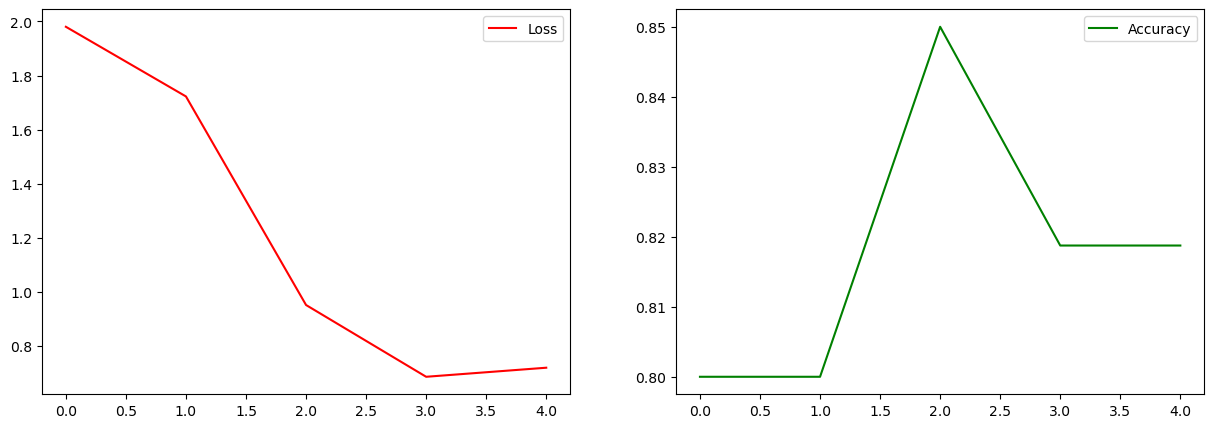

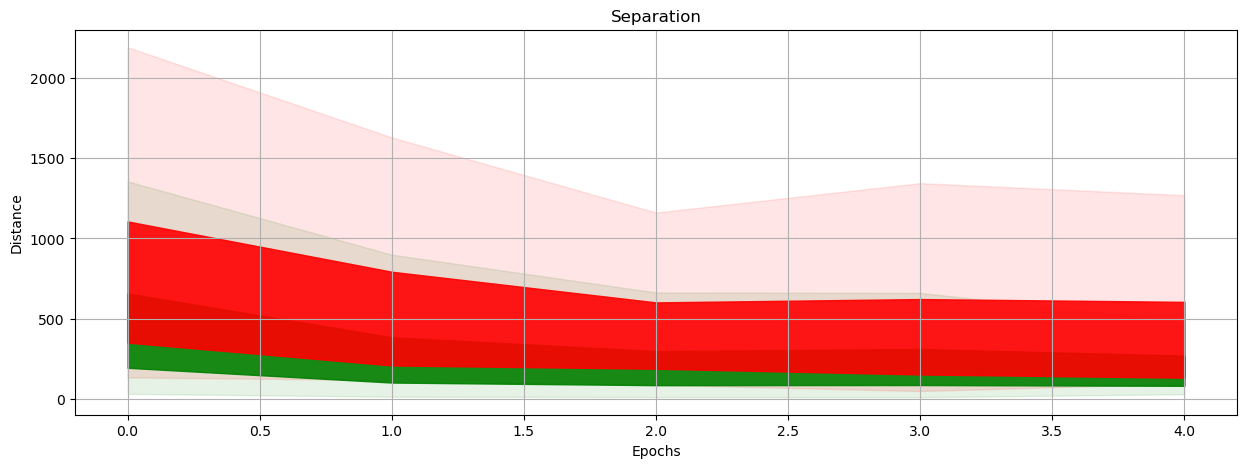

In [ ]:
def plot_metrics(loss, metrics):
    n = len(metrics)
    acc = np.zeros(n)
    pmean, pstd, pmin, pmax = np.zeros(n), np.zeros(n), np.zeros(n), np.zeros(n)
    nmean, nstd, nmin, nmax = np.zeros(n), np.zeros(n), np.zeros(n), np.zeros(n)

    for i, data in enumerate(metrics):
        acc[i] = data[0]
        pmean[i] = data[1][0]
        nmean[i] = data[1][1]
        pstd[i] = data[2][0]
        nstd[i] = data[2][1]
        pmin[i] = data[3][0]
        nmin[i] = data[3][1]
        pmax[i] = data[4][0]
        nmax[i] = data[4][1]

    pyplot.figure(figsize=(15,5))
    pyplot.subplot(1, 2, 1)
    pyplot.plot(loss, 'r', label='Loss')
    pyplot.legend()
    pyplot.subplot(1, 2, 2)
    pyplot.plot(acc, 'g', label='Accuracy')
    pyplot.legend()
    pyplot.show()

    pyplot.figure(figsize=(15,5))
    pyplot.title("Separation")
    pyplot.xlabel("Epochs")
    pyplot.ylabel("Distance")
    pyplot.grid()
    epochs = np.arange(n)
    pyplot.fill_between(epochs, pmin, pmax, alpha=0.1, color="g")
    pyplot.fill_between(epochs, nmin, nmax, alpha=0.1, color="r")
    pyplot.fill_between(epochs, pmean - pstd, pmean + pstd, alpha=0.9, color="g")
    pyplot.fill_between(epochs, nmean - nstd, nmean + nstd, alpha=0.9, color="r")
    pyplot.show()



plot_metrics(loss, metrics)

In [203]:
check_test_data(test_list, 188)

Acc: 0.9125 Means: (201.53584, 488.84625) stds: (356.32162, 625.50385)


[0.9125,
 (201.53584, 488.84625),
 (356.32162, 625.50385),
 (25.70827, 91.958496),
 (4482.045, 7525.174)]

# Training a yolo

In [20]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 616.3/616.3 kB 7.9 MB/s eta 0:00:00


# Dataset Conversion

##Train Jpgs

In [21]:
train_data = train_list.copy()
train_data

{'161': 2,
 '1610': 6,
 '1611': 4,
 '1612': 5,
 '1613': 3,
 '1614': 17,
 '1615': 5,
 '1616': 32,
 '1617': 2,
 '1618': 3,
 '1619': 5,
 '162': 3,
 '1620': 2,
 '1622': 3,
 '1623': 4,
 '1624': 2,
 '1625': 2,
 '1626': 4,
 '1627': 2,
 '1628': 3,
 '1629': 49,
 '163': 29,
 '1630': 3,
 '1631': 2,
 '1632': 7,
 '1633': 10,
 '1634': 2,
 '1635': 3,
 '1636': 2,
 '1637': 3,
 '1638': 5,
 '1639': 4,
 '164': 9,
 '1640': 13,
 '1641': 2,
 '1642': 3,
 '1643': 4,
 '1644': 2,
 '1645': 7,
 '1646': 7,
 '1647': 2,
 '1648': 5,
 '1649': 2,
 '165': 17,
 '1650': 2,
 '1651': 2,
 '1652': 24,
 '1653': 4,
 '1654': 4,
 '1655': 5,
 '1656': 3,
 '1657': 5,
 '1658': 5,
 '1659': 2,
 '166': 9,
 '1660': 8,
 '1661': 4,
 '1662': 7,
 '1663': 8,
 '1664': 4,
 '1665': 6,
 '1666': 14,
 '1667': 2,
 '1669': 2,
 '167': 10,
 '1670': 2,
 '1671': 4,
 '1673': 2,
 '1674': 2,
 '1675': 4,
 '1676': 9,
 '1678': 6,
 '1679': 4,
 '168': 2,
 '169': 2,
 '17': 12,
 '170': 4,
 '172': 2,
 '173': 7,
 '174': 2,
 '175': 2,
 '176': 2,
 '177': 2,
 '178': 2,


In [22]:
for key in train_data.keys():
  print(key)

161
1610
1611
1612
1613
1614
1615
1616
1617
1618
1619
162
1620
1622
1623
1624
1625
1626
1627
1628
1629
163
1630
1631
1632
1633
1634
1635
1636
1637
1638
1639
164
1640
1641
1642
1643
1644
1645
1646
1647
1648
1649
165
1650
1651
1652
1653
1654
1655
1656
1657
1658
1659
166
1660
1661
1662
1663
1664
1665
1666
1667
1669
167
1670
1671
1673
1674
1675
1676
1678
1679
168
169
17
170
172
173
174
175
176
177
178
179
18
181
182
183
184
185
186
187
188
189
19
190
191
192
193
194
195
196
197
198
199
2
20
200
201
202
204
205
206
207
208
209
21
210
211
212
213
214
215
216
217
218
22
220
221
222
223
224
225
227
228
229
23
230
231
232
233
234
235
236
237
238
239
24
240
241
242
243
244
245
248
249
25
251
252
253
254
255
256
257
258
259
26
260
261
262
264
265
266
267
268
269
27
270
271
273
274
275
276
277
278
279
28
280
281
282
283
284
285
286
287
288
289
29
290
291
292
293
294
295
296
297
298
299
3
30
300
301
302
303
304
305
306
307
308
309
31
310
311
312
313
314
315
316
317
318
319
32
320
321
323
324
325
32

In [23]:
train_directory = []
for key in train_data.keys():
    train_directory.append(f"/content/content/Othercomputers/Lenovo (1)/Machine_Learning/Miscellenous/Zeba/Face Dataset/{key}")

In [24]:
train_directory

['/content/content/Othercomputers/Lenovo (1)/Machine_Learning/Miscellenous/Zeba/Face Dataset/161',
 '/content/content/Othercomputers/Lenovo (1)/Machine_Learning/Miscellenous/Zeba/Face Dataset/1610',
 '/content/content/Othercomputers/Lenovo (1)/Machine_Learning/Miscellenous/Zeba/Face Dataset/1611',
 '/content/content/Othercomputers/Lenovo (1)/Machine_Learning/Miscellenous/Zeba/Face Dataset/1612',
 '/content/content/Othercomputers/Lenovo (1)/Machine_Learning/Miscellenous/Zeba/Face Dataset/1613',
 '/content/content/Othercomputers/Lenovo (1)/Machine_Learning/Miscellenous/Zeba/Face Dataset/1614',
 '/content/content/Othercomputers/Lenovo (1)/Machine_Learning/Miscellenous/Zeba/Face Dataset/1615',
 '/content/content/Othercomputers/Lenovo (1)/Machine_Learning/Miscellenous/Zeba/Face Dataset/1616',
 '/content/content/Othercomputers/Lenovo (1)/Machine_Learning/Miscellenous/Zeba/Face Dataset/1617',
 '/content/content/Othercomputers/Lenovo (1)/Machine_Learning/Miscellenous/Zeba/Face Dataset/1618',
 

In [25]:
train_jpgs = []

for directory in train_directory:
    # List all .jpg files in the directory
    train_jpg_files = [file for file in os.listdir(directory) if file.endswith('.jpg')]
    # Print the list of .jpg files (optional)
    for jpg_file in train_jpg_files:
    # Append the file paths to train_jpgs
      train_jpgs.extend([os.path.join(directory, jpg_file) for jpg_file in train_jpg_files])

In [26]:
train_jpgs

['/content/content/Othercomputers/Lenovo (1)/Machine_Learning/Miscellenous/Zeba/Face Dataset/161/0.jpg',
 '/content/content/Othercomputers/Lenovo (1)/Machine_Learning/Miscellenous/Zeba/Face Dataset/161/1.jpg',
 '/content/content/Othercomputers/Lenovo (1)/Machine_Learning/Miscellenous/Zeba/Face Dataset/161/0.jpg',
 '/content/content/Othercomputers/Lenovo (1)/Machine_Learning/Miscellenous/Zeba/Face Dataset/161/1.jpg',
 '/content/content/Othercomputers/Lenovo (1)/Machine_Learning/Miscellenous/Zeba/Face Dataset/1610/0.jpg',
 '/content/content/Othercomputers/Lenovo (1)/Machine_Learning/Miscellenous/Zeba/Face Dataset/1610/1.jpg',
 '/content/content/Othercomputers/Lenovo (1)/Machine_Learning/Miscellenous/Zeba/Face Dataset/1610/2.jpg',
 '/content/content/Othercomputers/Lenovo (1)/Machine_Learning/Miscellenous/Zeba/Face Dataset/1610/3.jpg',
 '/content/content/Othercomputers/Lenovo (1)/Machine_Learning/Miscellenous/Zeba/Face Dataset/1610/4.jpg',
 '/content/content/Othercomputers/Lenovo (1)/Machi

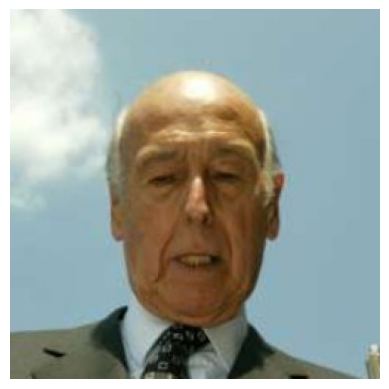

In [27]:
from PIL import Image
import matplotlib.pyplot as plt

# Define the file path of the image

# Open the image using PIL
image = Image.open(train_jpgs[5])

# Display the image using matplotlib
plt.imshow(image)
plt.axis('off')  # Turn off axis labels
plt.show()

## Test jpgs

In [28]:
test_data = test_list.copy()
test_data

{'1621': 7,
 '1668': 2,
 '1672': 2,
 '1677': 3,
 '171': 15,
 '180': 3,
 '203': 3,
 '219': 5,
 '226': 19,
 '246': 11,
 '247': 2,
 '250': 2,
 '263': 9,
 '272': 5,
 '322': 4,
 '336': 3,
 '347': 2,
 '358': 2,
 '362': 2,
 '365': 2,
 '370': 2,
 '371': 2,
 '411': 2,
 '418': 3,
 '419': 3,
 '44': 2,
 '45': 2,
 '451': 3,
 '458': 2,
 '46': 2,
 '463': 2,
 '465': 3,
 '470': 2,
 '475': 18,
 '480': 4,
 '489': 2,
 '491': 2,
 '512': 2,
 '514': 2,
 '523': 4,
 '529': 2,
 '54': 8,
 '565': 2,
 '585': 2,
 '601': 4,
 '605': 5,
 '614': 2,
 '618': 4,
 '62': 8,
 '622': 2,
 '624': 9,
 '654': 50,
 '667': 11,
 '676': 5,
 '677': 2,
 '678': 2,
 '679': 3,
 '72': 2,
 '730': 2,
 '732': 4,
 '736': 3,
 '756': 2,
 '759': 2,
 '764': 4,
 '771': 9,
 '78': 2,
 '787': 3,
 '803': 5,
 '815': 4,
 '819': 2,
 '827': 3,
 '85': 15,
 '869': 4,
 '914': 2,
 '928': 4,
 '949': 3,
 '950': 3,
 '979': 3,
 '988': 5,
 '990': 4,
 '997': 3,
 '10': 4,
 '1002': 5,
 '1014': 5,
 '102': 2,
 '1024': 8,
 '1038': 2,
 '1040': 2,
 '1046': 4,
 '1059': 2,
 

In [29]:
for key in test_data.keys():
  print(key)

1621
1668
1672
1677
171
180
203
219
226
246
247
250
263
272
322
336
347
358
362
365
370
371
411
418
419
44
45
451
458
46
463
465
470
475
480
489
491
512
514
523
529
54
565
585
601
605
614
618
62
622
624
654
667
676
677
678
679
72
730
732
736
756
759
764
771
78
787
803
815
819
827
85
869
914
928
949
950
979
988
990
997
10
1002
1014
102
1024
1038
1040
1046
1059
1065
1069
1074
1115
1117
1128
1135
1143
1145
1176
1181
1224
1230
1258
1291
13
130
1301
1304
1307
1314
1335
136
1391
1394
1406
1408
1422
1440
1451
1459
1461
1474
149
1491
1515
1517
1519
1535
1548
1574
1575
1583
1590
1598
160
1603


In [30]:
test_directory = []
for key in train_data.keys():
    test_directory.append(f"/content/content/Othercomputers/Lenovo (1)/Machine_Learning/Miscellenous/Zeba/Face Dataset/{key}")

In [31]:
test_jpgs = []

for directory in test_directory:
    # List all .jpg files in the directory
    train_jpg_files = [file for file in os.listdir(directory) if file.endswith('.jpg')]
    # Print the list of .jpg files (optional)
    for jpg_file in train_jpg_files:
    # Append the file paths to train_jpgs
      test_jpgs.extend([os.path.join(directory, jpg_file) for jpg_file in train_jpg_files])

In [32]:
test_jpgs[1]

'/content/content/Othercomputers/Lenovo (1)/Machine_Learning/Miscellenous/Zeba/Face Dataset/161/1.jpg'

In [33]:
# import yaml
# import base64
# import os

# # List of image file paths
# image_paths = train_jpgs

# # Output directory for YAML files
# output_dir = '/content/content/Othercomputers/Lenovo (1)/Machine_Learning/Miscellenous/Zeba/yaml_output'
# os.makedirs(output_dir, exist_ok=True)

# for i, image_path in enumerate(image_paths):
#     # Load the image data
#     with open(image_path, 'rb') as image_file:
#         image_data = image_file.read()

#     # Encode the image data (base64 encoding)
#     encoded_image = base64.b64encode(image_data).decode()

#     # Create a YAML dictionary for each image
#     yaml_data = {
#         'image_data': encoded_image,
#         'metadata': {
#             'width': 800,  # Update with actual image width
#             'height': 600,  # Update with actual image height
#             'format': 'JPEG'  # Update with actual image format
#         }
#     }

#     # Generate a YAML file name based on the image index
#     yaml_file_name = f'image_{i}.yaml'
#     yaml_file_path = os.path.join(output_dir, yaml_file_name)

#     # Write the YAML dictionary to the YAML file
#     with open(yaml_file_path, 'w') as yaml_file:
#         yaml.dump(yaml_data, yaml_file)

#     print(f"Image {i + 1}: Image data has been saved to {yaml_file_path}.")

# print("All images have been converted to YAML files.")

In [34]:
from ultralytics import YOLO

# Load a model
# model = YOLO("yolov8n.yaml")  # build a new model from scratch
yolo_model = YOLO("yolov5n.pt")  # load a pretrained model (recommended for training)

# Use the model
yolo_model.train(data="coco128.yaml", epochs=3)  # train the model

# path = "ML_Projects/Zeba/"

PRO TIP 💡 Replace 'model=yolov5n.pt' with new 'model=yolov5nu.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.

100%|██████████| 5.27M/5.27M [00:00<00:00, 46.4MB/s]
Ultralytics YOLOv8.0.176 🚀 Python-3.10.12 torch-2.0.1+cu118 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov5n.pt, data=coco128.yaml, epochs=3, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, sourc

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 11, 13, 14, 15, 16, 17, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 68, 69, 71, 72, 73, 74, 75, 76, 77, 79])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e0c5712bac0>
fitness: 0.4492085991537802
keys: ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']
maps: array([    0.51077,     0.31683,     0.16098,     0.70214,     0.62795,     0.67169,     0.74103,     0.21011,     0.11124,     0.15005,     0.43307,     0.74698,     0.43307,     0.21148,     0.57724,     0.77971,     0.66974,     0.79573,     0.43307,     0.43307,     0.68188,       0.995,     0.92152,      0.6652,
           0.30831,     0.39239,    0.075217,     

In [35]:
metrics = yolo_model.val()  # evaluate model performance on the validation set

Ultralytics YOLOv8.0.176 🚀 Python-3.10.12 torch-2.0.1+cu118 CPU (Intel Xeon 2.20GHz)
YOLOv5n summary (fused): 193 layers, 2649200 parameters, 0 gradients
val: Scanning /content/datasets/coco128/labels/train2017.cache... 126 images, 2 backgrounds, 0 corrupt: 100%|██████████| 128/128 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:30<00:00,  3.75s/it]
                   all        128        929      0.594      0.534       0.59      0.432
                person        128        254      0.779      0.709       0.76      0.515
               bicycle        128          6      0.624      0.291      0.503      0.316
                   car        128         46      0.655      0.174      0.219      0.159
            motorcycle        128          5      0.828      0.967      0.962      0.707
              airplane        128          6      0.682      0.833      0.903      0.628
                   bus        

In [36]:
path = yolo_model.export(format="onnx")  # export the model to ONNX format

Ultralytics YOLOv8.0.176 🚀 Python-3.10.12 torch-2.0.1+cu118 CPU (Intel Xeon 2.20GHz)

PyTorch: starting from 'runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 84, 8400) (5.3 MB)
requirements: Ultralytics requirement ['onnx>=1.12.0'] not found, attempting AutoUpdate...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 66.4 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 9.5s, installed 1 package: ['onnx>=1.12.0']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.14.1 opset 17...
ONNX: export success ✅ 11.5s, saved as 'runs/detect/train/weights/best.onnx' (10.3 MB)

Export complete (13.2s)
Results saved to /content/runs/detect/train/weights
Predict:         yolo predict task=detect model=runs/detect/train/weights/best.onnx imgsz=640  
Validate:        yolo val task=detect model=runs/detect/train/weights/best.onnx imgsz=640 data=/usr/local/lib/python3.10/dist-packa

============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [37]:
results = yolo_model(test_jpgs[5])  # predict on an image


image 1/1 /content/content/Othercomputers/Lenovo (1)/Machine_Learning/Miscellenous/Zeba/Face Dataset/1610/1.jpg: 640x640 1 person, 1 tie, 350.4ms
Speed: 4.6ms preprocess, 350.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)


In [80]:
# results=model.predict('https://ultralytics.com/images/bus.jpg', save=True, imgsz=320, conf=0.5)

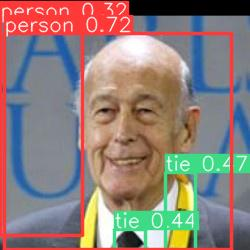

In [38]:
results

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted p

In [50]:
from PIL import Image

#Predicting on the test image

In [116]:
# Show the results
for r in results:
    im_array = r.plot()  # plot a BGR numpy array of predictions
    im = Image.fromarray(im_array[..., ::-1])  # RGB PIL image
    # im.show()  # show image
    im.save('results.jpg')  # save image

In [173]:
# for box in results[0].boxes:
#   class_id = box.cls[0].item()
#   conf = box.conf[0].item()
#   print(class_id, conf)

0.0 0.8513917326927185
27.0 0.37892600893974304


In [ ]:
# preds_outputs = "/content/content/Othercomputers/Lenovo (1)/Machine_Learning/Miscellenous/Zeba/predicted"
# os.makedirs(preds_outputs, exist_ok=True)

In [93]:
target_size = (224, 224)
# integrate object detection, image cropping, and similarity prediction into a single pipeline
def detect_person(image_path, id_value=0, conf_value=0.5, preds_outputs="/content/content/Othercomputers/Lenovo (1)/Machine_Learning/Miscellenous/Zeba/predicted"):
    # Initialize index for saving images
    idx = 0
    os.makedirs(preds_outputs, exist_ok=True)
    # Read the image using OpenCV
    image = cv2.imread(image_path)

    # Perform object detection using YOLO model
    results = yolo_model(image)

    # Initialize lists to store cropped images and file paths
    cropped_images = []
    file_paths = []

    # Loop through detected objects
    for box in results[0].boxes:
        class_id = box.cls[0].item()
        conf = box.conf[0].item()

        # Check if the detected object is a person and confidence is above the threshold
        if class_id == id_value and conf > conf_value:
            # Extract coordinates
            x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())

            # Crop the region corresponding to the person
            cropped_image = image[y1:y2, x1:x2]
            cropped_images.append(cropped_image)

            # Save the cropped image
            file_path = f"{preds_outputs}/person_{idx}.jpg"
            cv2.imwrite(file_path, cropped_image)
            file_paths.append(file_path)

            # Print save confirmation
            print(f"File has been saved to {file_path}")

            # Increment index for next image
            idx += 1

    return cropped_images, file_path
def load_and_resize_image(image_path, target_size= target_size):
    # Load the image
    image = cv2.imread(image_path)

    # Resize the image to the target size
    image = cv2.resize(image, target_size)

    # Convert the image to the required format (e.g., RGB for most models)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    return image

def predict_similarity(image1, image2, image3,target_size=target_size):
    # idx =0
    # Preprocess and normalize the input images if necessary
    # ...
    image, file_path1 = detect_person(image_path=image1, id_value=0, conf_value=0.5, preds_outputs="/content/content/Othercomputers/Lenovo (1)/Machine_Learning/Miscellenous/Zeba/predicted1")
    image1 = load_and_resize_image(file_path1, target_size)
    image, file_path2 = detect_person(image_path=image2, id_value=0, conf_value=0.5, preds_outputs="/content/content/Othercomputers/Lenovo (1)/Machine_Learning/Miscellenous/Zeba/predicted2")
    image2 = load_and_resize_image(file_path2, target_size)
    image, file_path3 = detect_person(image_path=image3, id_value=0, conf_value=0.5, preds_outputs="/content/content/Othercomputers/Lenovo (1)/Machine_Learning/Miscellenous/Zeba/predicted3")
    image3 = load_and_resize_image(file_path3, target_size)
    # Expand dimensions to match Siamese network input shape
    image1 = np.expand_dims(image1, axis=0)
    image2 = np.expand_dims(image2, axis=0)
    image3 = np.expand_dims(image3, axis=0)


    # Compute the similarity score
    similarity_score = siamese_model.predict([image1, image2, image3])

    # Since siamese_model.predict returns a list, extract the score
    # similarity_score = similarity_score[0][0]

    return similarity_score
# Define the target size (e.g., (299, 299) for a common size)
target_size = (299, 299)
image1 = test_jpgs[20]  # anchor
image2 = test_jpgs[21]   #positive
image3 =  test_jpgs[40]  # negative
# Make predictions between image1 and image2 and image3
similarity_score123 = predict_similarity(image1, image2, image3, target_size=target_size)

print("Similarity Score :", similarity_score123)


0: 640x640 1 person, 1 tie, 255.2ms
Speed: 4.9ms preprocess, 255.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)



File has been saved to /content/content/Othercomputers/Lenovo (1)/Machine_Learning/Miscellenous/Zeba/predicted1/person_0.jpg


0: 640x640 2 persons, 2 ties, 247.4ms
Speed: 5.2ms preprocess, 247.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)



File has been saved to /content/content/Othercomputers/Lenovo (1)/Machine_Learning/Miscellenous/Zeba/predicted2/person_0.jpg


0: 640x640 1 person, 219.2ms
Speed: 5.7ms preprocess, 219.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


File has been saved to /content/content/Othercomputers/Lenovo (1)/Machine_Learning/Miscellenous/Zeba/predicted3/person_0.jpg
1/1 [==============================] - 1s 1s/step
Similarity Score : (array([     289.78], dtype=float32), array([     846.58], dtype=float32))


In [94]:
similarity_score123

#distance between anchor and positive(should be less)        # distance between anchor and negative(should be more)

(array([     289.78], dtype=float32), array([     846.58], dtype=float32))

Interpretation:
array([289.78], dtype=float32): This is the distance between the anchor image (image1) and the positive image (image2). In the context of face recognition, a smaller distance means that the two images are more similar. So, a value of 289.78 suggests that image1 and image2 are relatively close in the feature space, implying they are likely to be of the same person (or the same class of objects, depending on your application).

array([846.58], dtype=float32): This is the distance between the anchor image (image1) and the negative image (image3). A larger distance means that the two images are dissimilar. A value of 846.58 suggests that image1 and image3 are far apart in the feature space, implying they are likely to be of different people (or different classes of objects).

In [80]:
# Extract distances from similarity_score123
anchor_positive_distance = similarity_score123[0][0]  # 289.78 in your example
anchor_negative_distance = similarity_score123[1][0]  # 846.58 in your example

# Apply Thresholding
threshold = 500  # You can adjust this value based on your needs

is_anchor_positive_same_person = anchor_positive_distance < threshold
is_anchor_negative_same_person = anchor_negative_distance < threshold

print(f"Is anchor and positive the same person? {is_anchor_positive_same_person}")
print(f"Is anchor and negative the same person? {is_anchor_negative_same_person}")

Is anchor and positive the same person? True
Is anchor and negative the same person? False


In [86]:
list[1]

['anchor', 'positive', 'negative']

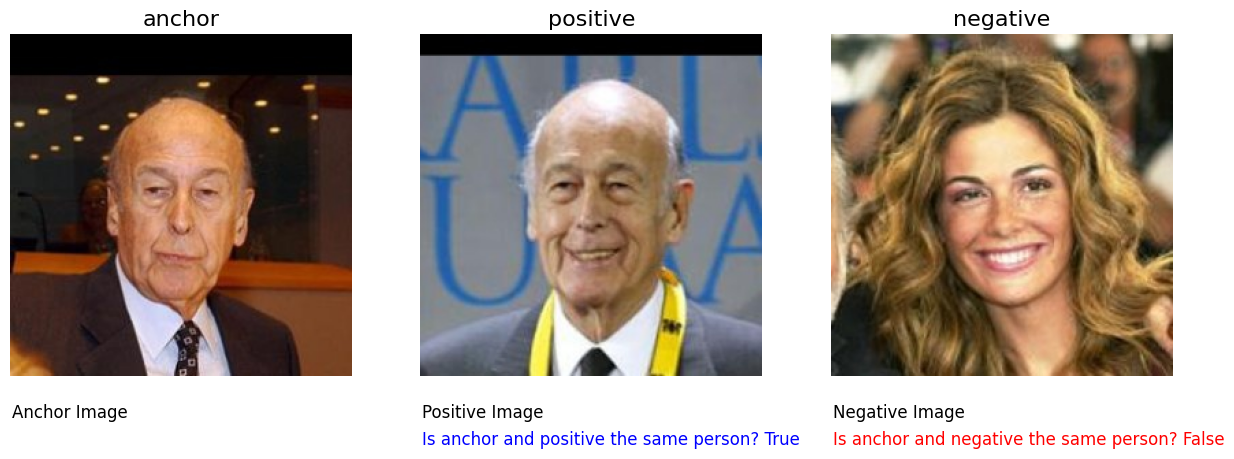

In [111]:
from PIL import Image
import matplotlib.pyplot as plt

# List of image paths
image_paths = [train_jpgs[20], train_jpgs[21], train_jpgs[40]]

# Corresponding labels
labels = ["anchor", "positive", "negative"]

# Your similarity scores (replace these with your actual values)
# similarity_score123 = (289.78, 846.58)  # Example values
anchor_positive_distance = similarity_score123[0][0]
anchor_negative_distance = similarity_score123[1][0]

# Apply Thresholding
threshold = 500  # You can adjust this value based on your needs
is_anchor_positive_same_person = anchor_positive_distance < threshold
is_anchor_negative_same_person = anchor_negative_distance < threshold

# Create a figure and a grid of subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Loop through image paths, labels, and subplots
for image_path, label, ax in zip(image_paths, labels, axs):
    # Open the image using PIL
    image = Image.open(image_path)
    x=1
    y=300
    # Display the image
    ax.imshow(image)
    ax.set_title(label, fontsize=16)
    ax.axis('off')  # Turn off axis labels

    # Add text annotations based on the label
    if label == "anchor":
        ax.text(x, y-20, f"Anchor Image", fontsize=12, color='Black')
    elif label == "positive":
        ax.text(x, y-20, f"Positive Image", fontsize=12, color='Black')
        ax.text(x, y, f"Is anchor and positive the same person? {is_anchor_positive_same_person}", fontsize=12, color='blue')
    elif label == "negative":
        ax.text(x, y-20, f"Negative Image", fontsize=12, color='Black')
        ax.text(x, y, f"Is anchor and negative the same person? {is_anchor_negative_same_person}", fontsize=12, color='red')

# Show the plot
plt.show()


In [114]:
anchor_positive_distance < threshold

True

In [115]:
import datetime

# Initialize an empty array to store attendance
attendance_array = []

# Function to mark attendance
def mark_attendance(person_name):
    current_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    attendance_entry = {"name": person_name, "time": current_time}
    attendance_array.append(attendance_entry)
    print(f"Attendance marked for {person_name} at {current_time}")

# Apply Thresholding
threshold = 500  # You can adjust this value based on your needs

is_anchor_positive_same_person = anchor_positive_distance < threshold
is_anchor_negative_same_person = anchor_negative_distance < threshold

print(f"Is anchor and positive the same person? {is_anchor_positive_same_person}")
print(f"Is anchor and negative the same person? {is_anchor_negative_same_person}")

# If anchor and positive are the same person, mark attendance
if is_anchor_positive_same_person:
    person_name = "Person A"  # Replace with the actual name or ID
    mark_attendance(person_name)

# Print the attendance array to verify
print("Attendance:", attendance_array)


Is anchor and positive the same person? True
Is anchor and negative the same person? False
Attendance marked for Person A at 2023-09-12 23:56:17
Attendance: {'Person A': '2023-09-12 23:56:17'}
